In [1]:
import pertpy as pt
import scanpy as sc
import pandas as pd
import numpy as np
import scvi
import torch
from _quasiSCVI import QuasiSCVI
from _quasivae import QuasiVAE
from anndata import AnnData

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
# Load a sample dataset
mdata = pt.dt.papalexi_2021()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name beca

In [3]:
sc.pp.normalize_total(mdata["rna"])
sc.pp.log1p(mdata["rna"])
sc.pp.highly_variable_genes(mdata["rna"],n_top_genes=2000, batch_key="replicate",  subset=True)

In [4]:
gdo = mdata.mod["gdo"]
# Extract the guide count matrix
guide_count_matrix = gdo.X

guide_count_df = pd.DataFrame(guide_count_matrix.toarray(), index=gdo.obs.index, columns=gdo.var.index)

In [5]:
guide_adata = sc.AnnData(X=guide_count_df.values)
guide_adata.obs.index = guide_count_df.index
guide_adata.var.index = guide_count_df.columns
guide_adata.obs['replicate'] = mdata["rna"].obs['replicate']
guide_adata.obs['Phase'] = mdata["rna"].obs['Phase']
guide_adata.obs['perturbation'] = mdata["rna"].obs['perturbation']
guide_adata.obs['guide']= mdata["rna"].obs['NT']
# Inspect the AnnData object
print(guide_adata)

AnnData object with n_obs × n_vars = 20729 × 111
    obs: 'replicate', 'Phase', 'perturbation', 'guide'


In [6]:
scvi.model.SCVI.setup_anndata(guide_adata)

In [7]:
scvi_ref = scvi.model.SCVI(
    guide_adata,
    use_layer_norm="both",
    use_batch_norm="none",
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
)
#scvi_ref.train()

In [8]:
#scvi_ref.save('scvi_model_gbc')

In [9]:
scvi_ref = scvi.model.SCVI.load('scvi_model_gbc', adata = guide_adata)

INFO     File scvi_model_gbc/model.pt already downloaded                                                           


/var/folders/3k/yfw07yqn6nbdwjkxhf022b2m0000gn/T/ipykernel_50953/3896887414.py:5: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(guide_adata)


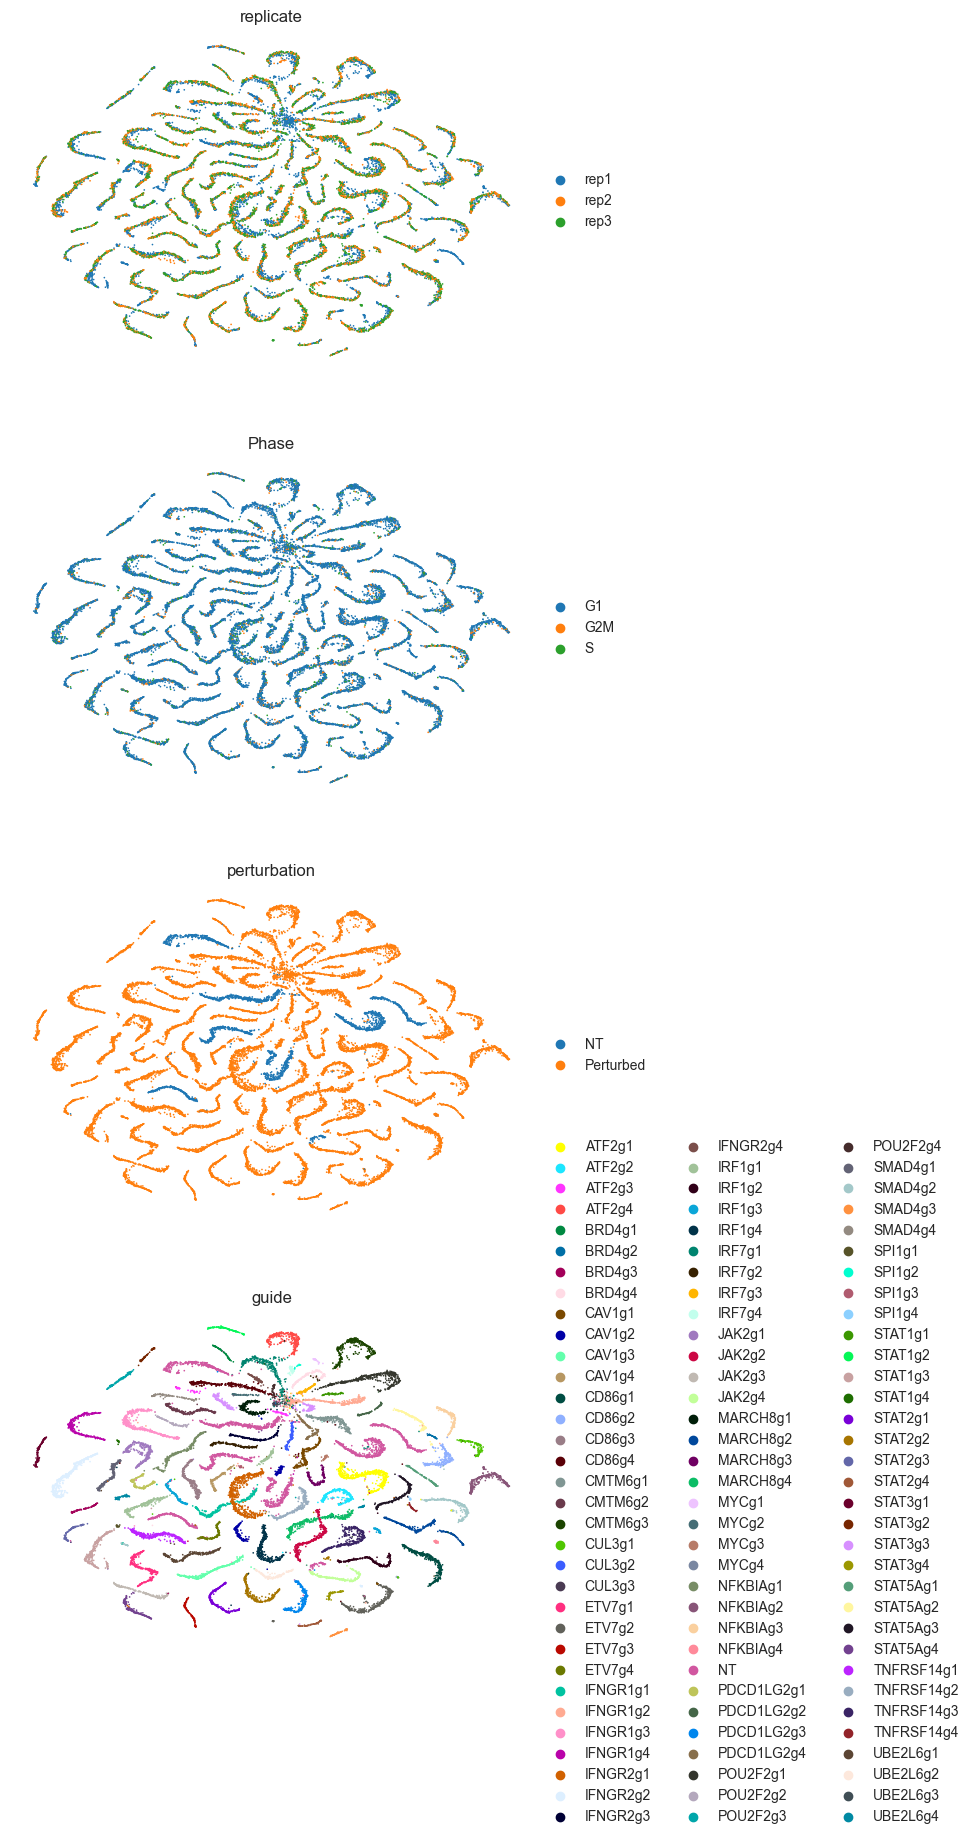

In [10]:
SCVI_LATENT_KEY = "X_scVI"

guide_adata.obsm[SCVI_LATENT_KEY] = scvi_ref.get_latent_representation()
sc.pp.neighbors(guide_adata, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(guide_adata)
sc.tl.umap(guide_adata)
sc.pl.umap(
    guide_adata,
    color=["replicate", "Phase", "perturbation","guide"],
    frameon=False,
    ncols=1,
)

In [11]:
qzm, qzv = scvi_ref.get_latent_representation(adata=guide_adata, give_mean=False, return_dist=True)
print("Shape of qzm:", qzm.shape)
print("Shape of qzv:", qzv.shape)
# qzm = torch.tensor(qzm, dtype=torch.float32)
# qzv = torch.tensor(qzv, dtype=torch.float32)

Shape of qzm: (20729, 10)
Shape of qzv: (20729, 10)


In [12]:
guide_embeddings = scvi_ref.get_latent_representation()
adata_ref = mdata["rna"].copy()


In [13]:
guide_adata.shape

(20729, 111)

In [14]:
adata_ref.shape

(20729, 2000)

In [15]:
adata_ref.obsm['gbc_qzm'] = qzm
adata_ref.obsm['gbc_qzv'] = qzv

In [16]:
QuasiSCVI.setup_anndata(adata_ref, batch_key='replicate', gbc_qzm_key = 'gbc_qzm', gbc_qzv_key = 'gbc_qzv' )


INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


In [17]:
qzm.shape

(20729, 10)

In [18]:
guide_model = QuasiSCVI(
    adata_ref,
    use_layer_norm="both",
    use_batch_norm="none",
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
    #gbc_latent_dim=10,
    
    
)



In [19]:
guide_model # .module.gbc_latent_dim

QuasiSCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 2, dropout_rate: 0.2, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [20]:
# Train the model
guide_model.train(max_epochs=500) #  plan_kwargs={"lr": 1e-4}, accelerator='gpu'

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 500/500: 100%|████████████████████████████████████████████████████████| 500/500 [26:35<00:00,  3.06s/it, v_num=1, train_loss_step=24.4, train_loss_epoch=22.6]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|████████████████████████████████████████████████████████| 500/500 [26:35<00:00,  3.19s/it, v_num=1, train_loss_step=24.4, train_loss_epoch=22.6]


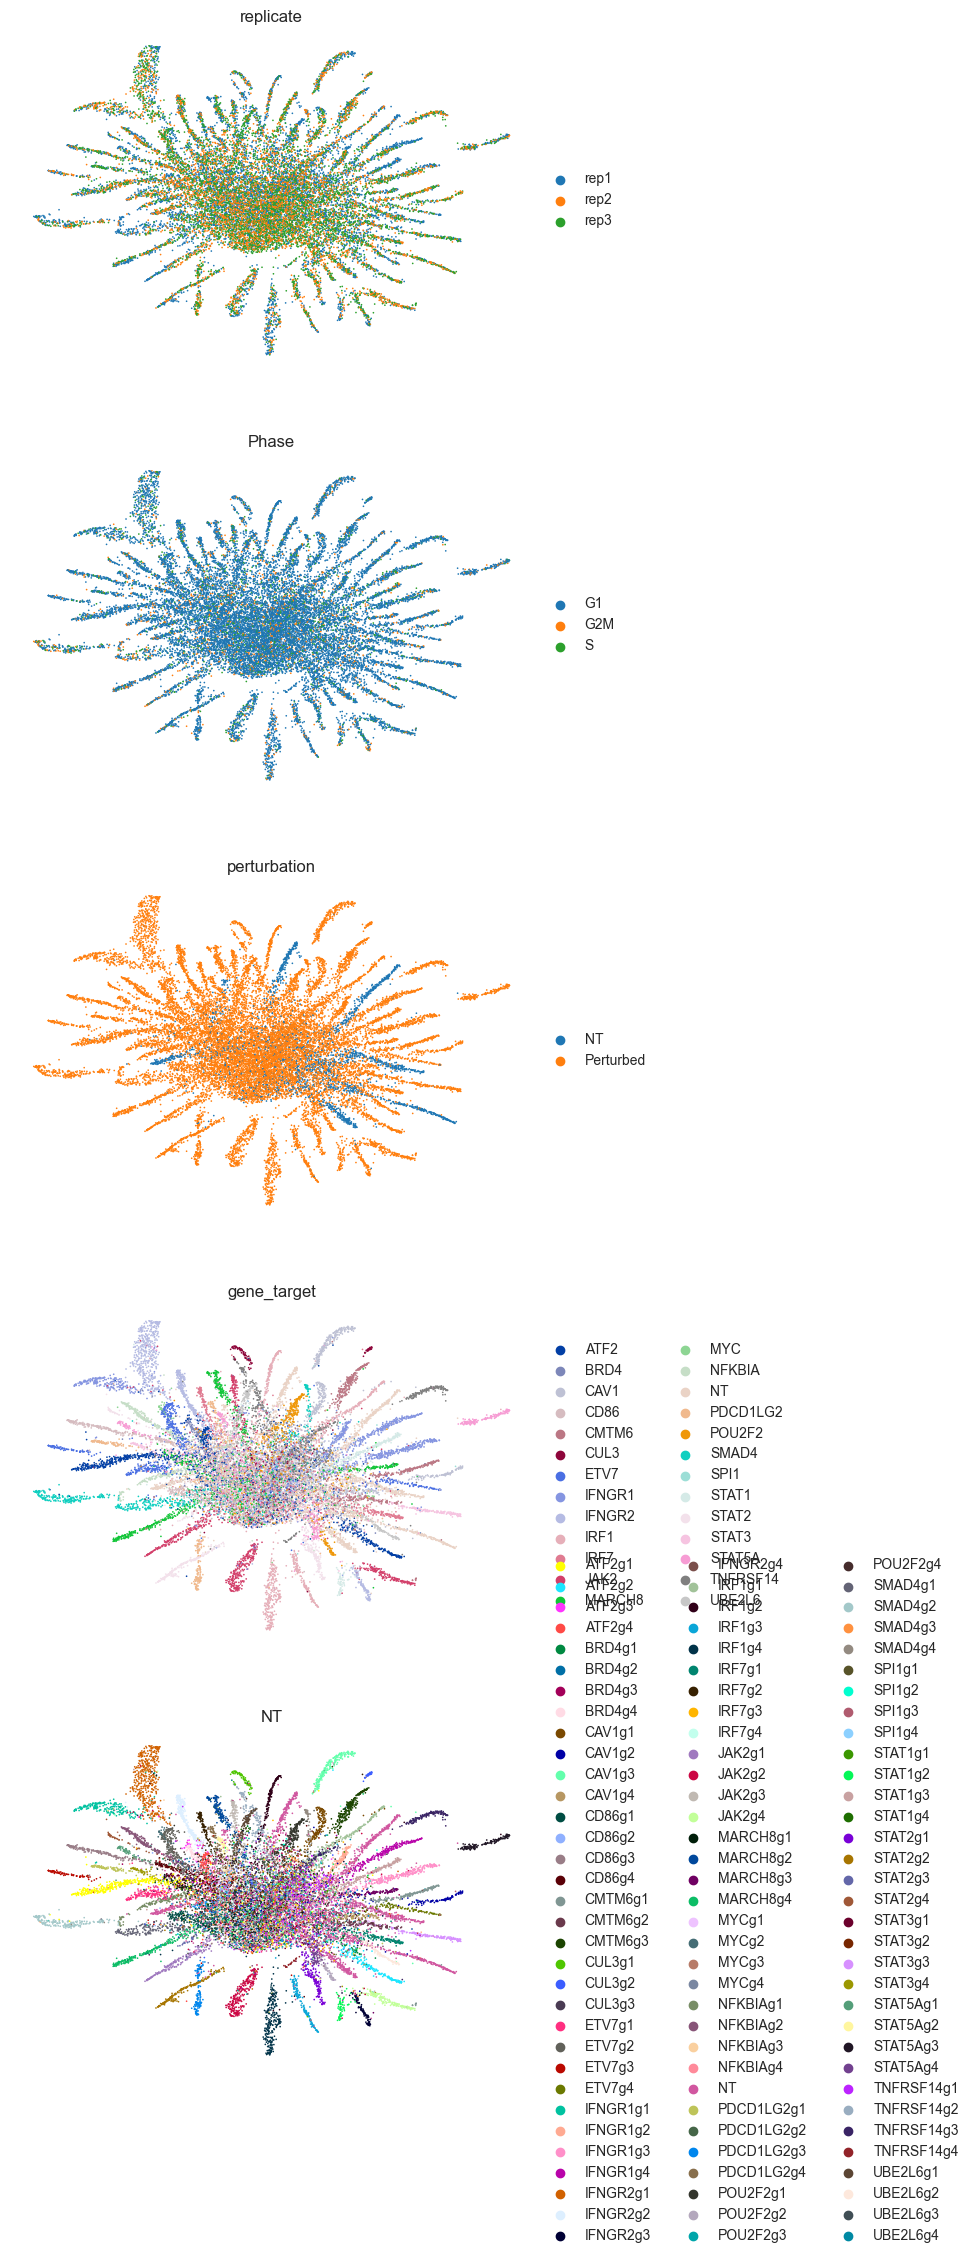

In [21]:
SCVI_LATENT_KEY = "X_scVI"

adata_ref.obsm[SCVI_LATENT_KEY] = guide_model.get_latent_representation()
sc.pp.neighbors(adata_ref, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(adata_ref)
sc.tl.umap(adata_ref)
sc.pl.umap(
    adata_ref,
    color=["replicate", "Phase","perturbation","gene_target"],
    frameon=False,
    ncols=1,
)

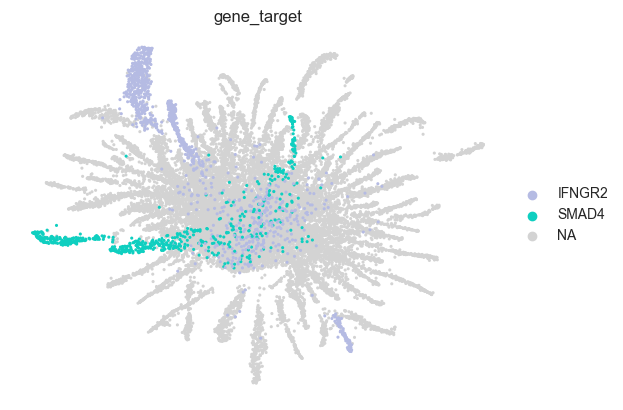

In [22]:
sc.pl.umap(
    adata_ref,
    color=["gene_target"],
    groups = ['SMAD4', 'IFNGR2'],
    frameon=False,
    size = 20,
    ncols=1,
)

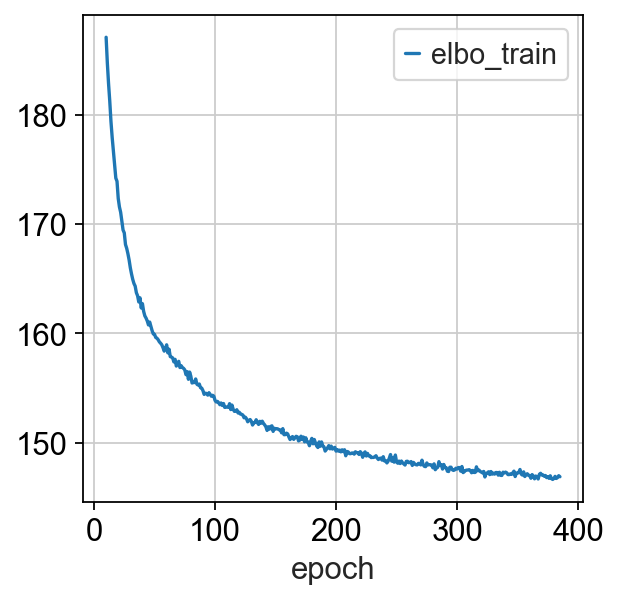

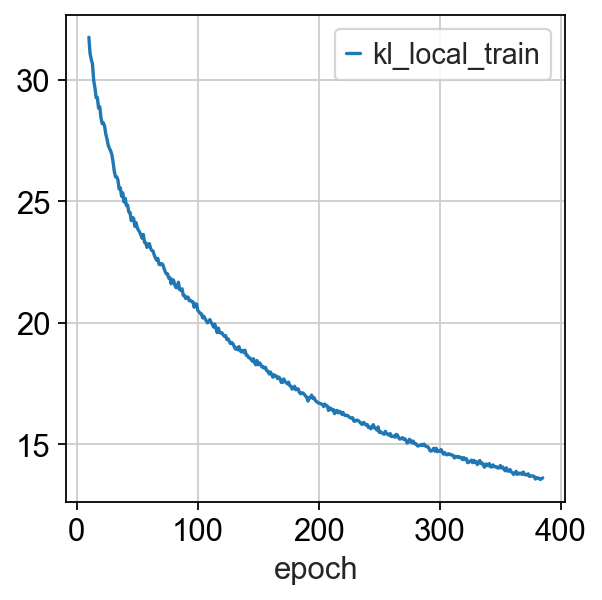

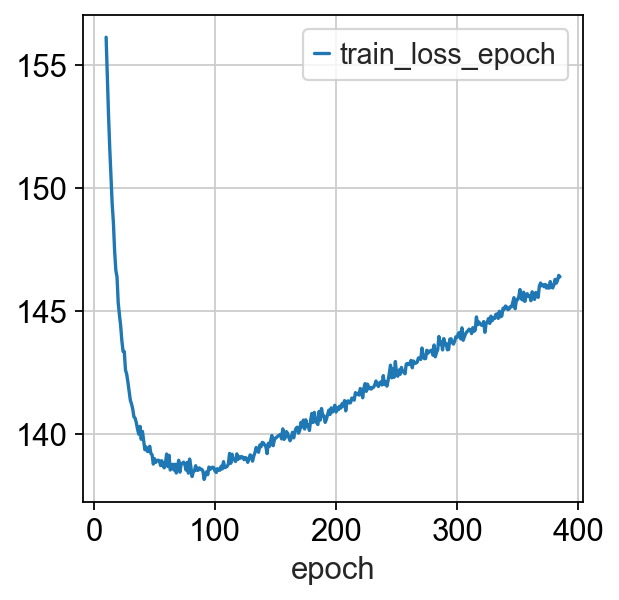

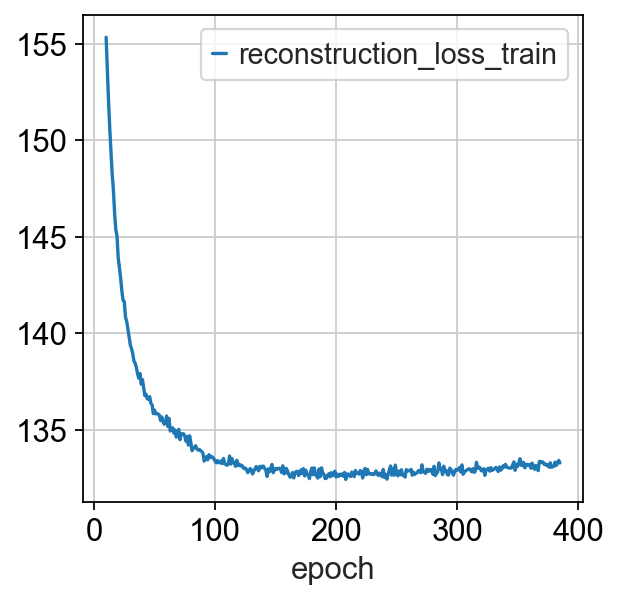

In [23]:
sc.set_figure_params(figsize=(4, 4))
import matplotlib.pyplot as plt
scvi_ref.history["elbo_train"].iloc[10:].plot()
plt.show()


scvi_ref.history["kl_local_train"].iloc[10:].plot()
plt.show()


scvi_ref.history["train_loss_epoch"].iloc[10:].plot()
plt.show()

scvi_ref.history["reconstruction_loss_train"].iloc[10:].plot()
plt.show()

In [24]:
scvi_ref.history["elbo_train"]
train_loss = scvi_ref.history["elbo_train"]
kl_divergence = scvi_ref.history["kl_local_train"]

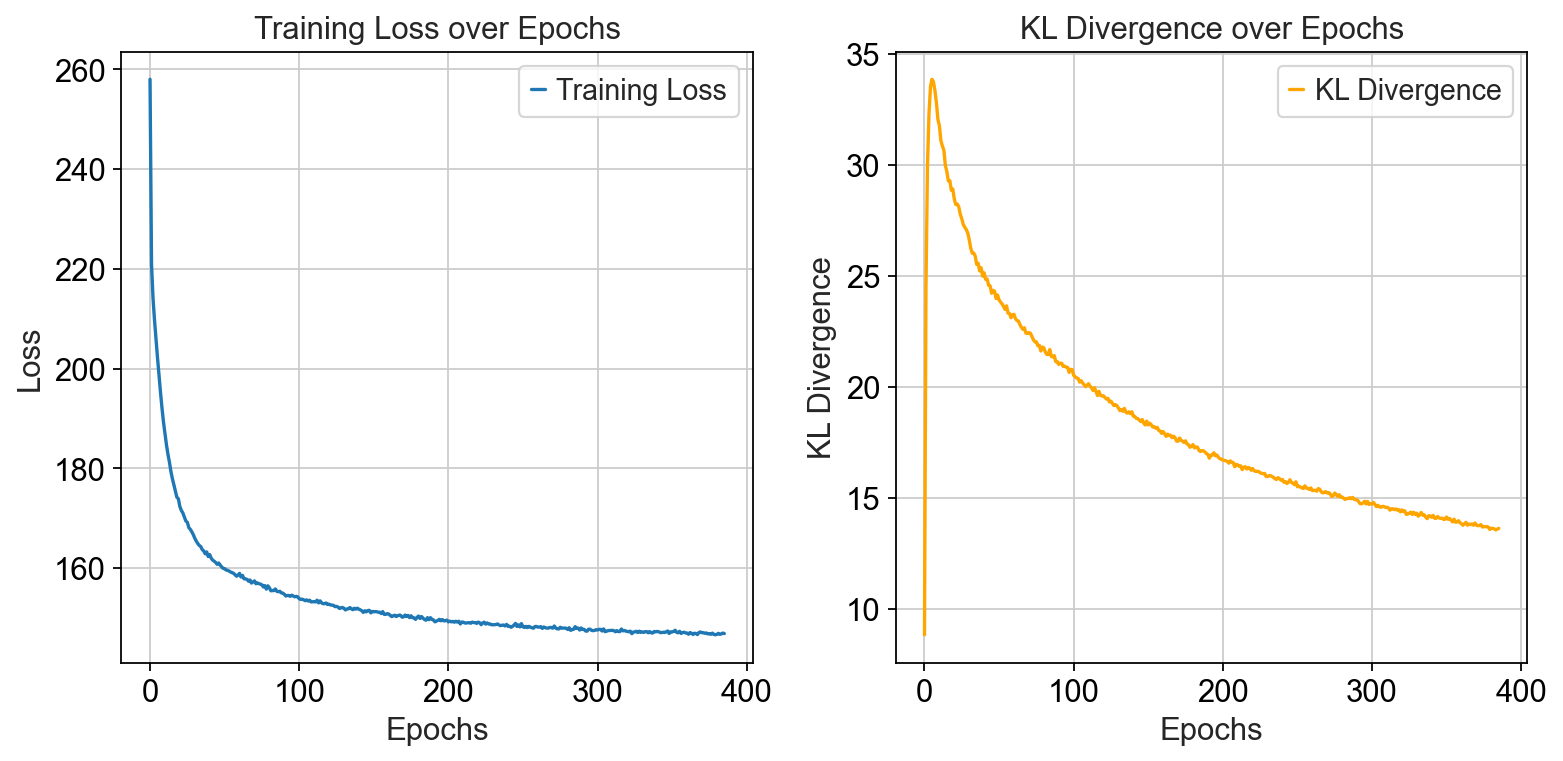

In [25]:
import matplotlib.pyplot as plt

# Plot training loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

# Plot KL divergence
plt.subplot(1, 2, 2)
plt.plot(kl_divergence, label='KL Divergence', color='orange')
plt.xlabel('Epochs')
plt.ylabel('KL Divergence')
plt.title('KL Divergence over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

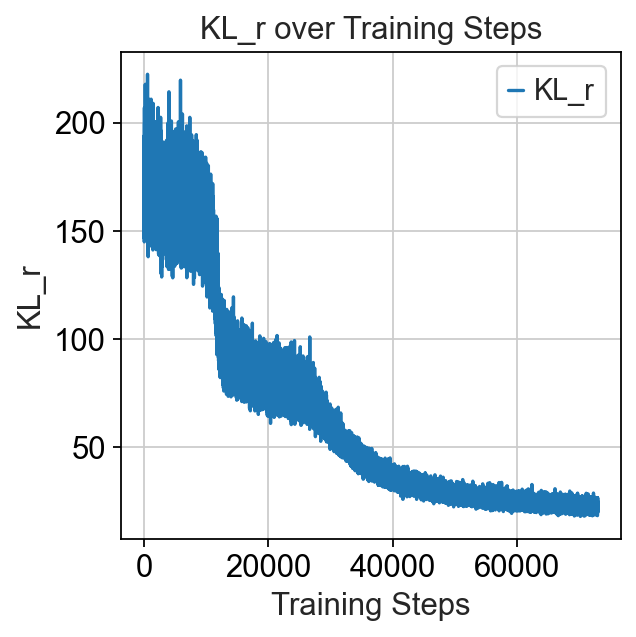

In [26]:

kl_r_values = guide_model.module.kl_r_log
plt.plot(kl_r_values, label='KL_r')
plt.xlabel('Training Steps')
plt.ylabel('KL_r')
plt.title('KL_r over Training Steps')
plt.legend()
plt.show()


Output()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


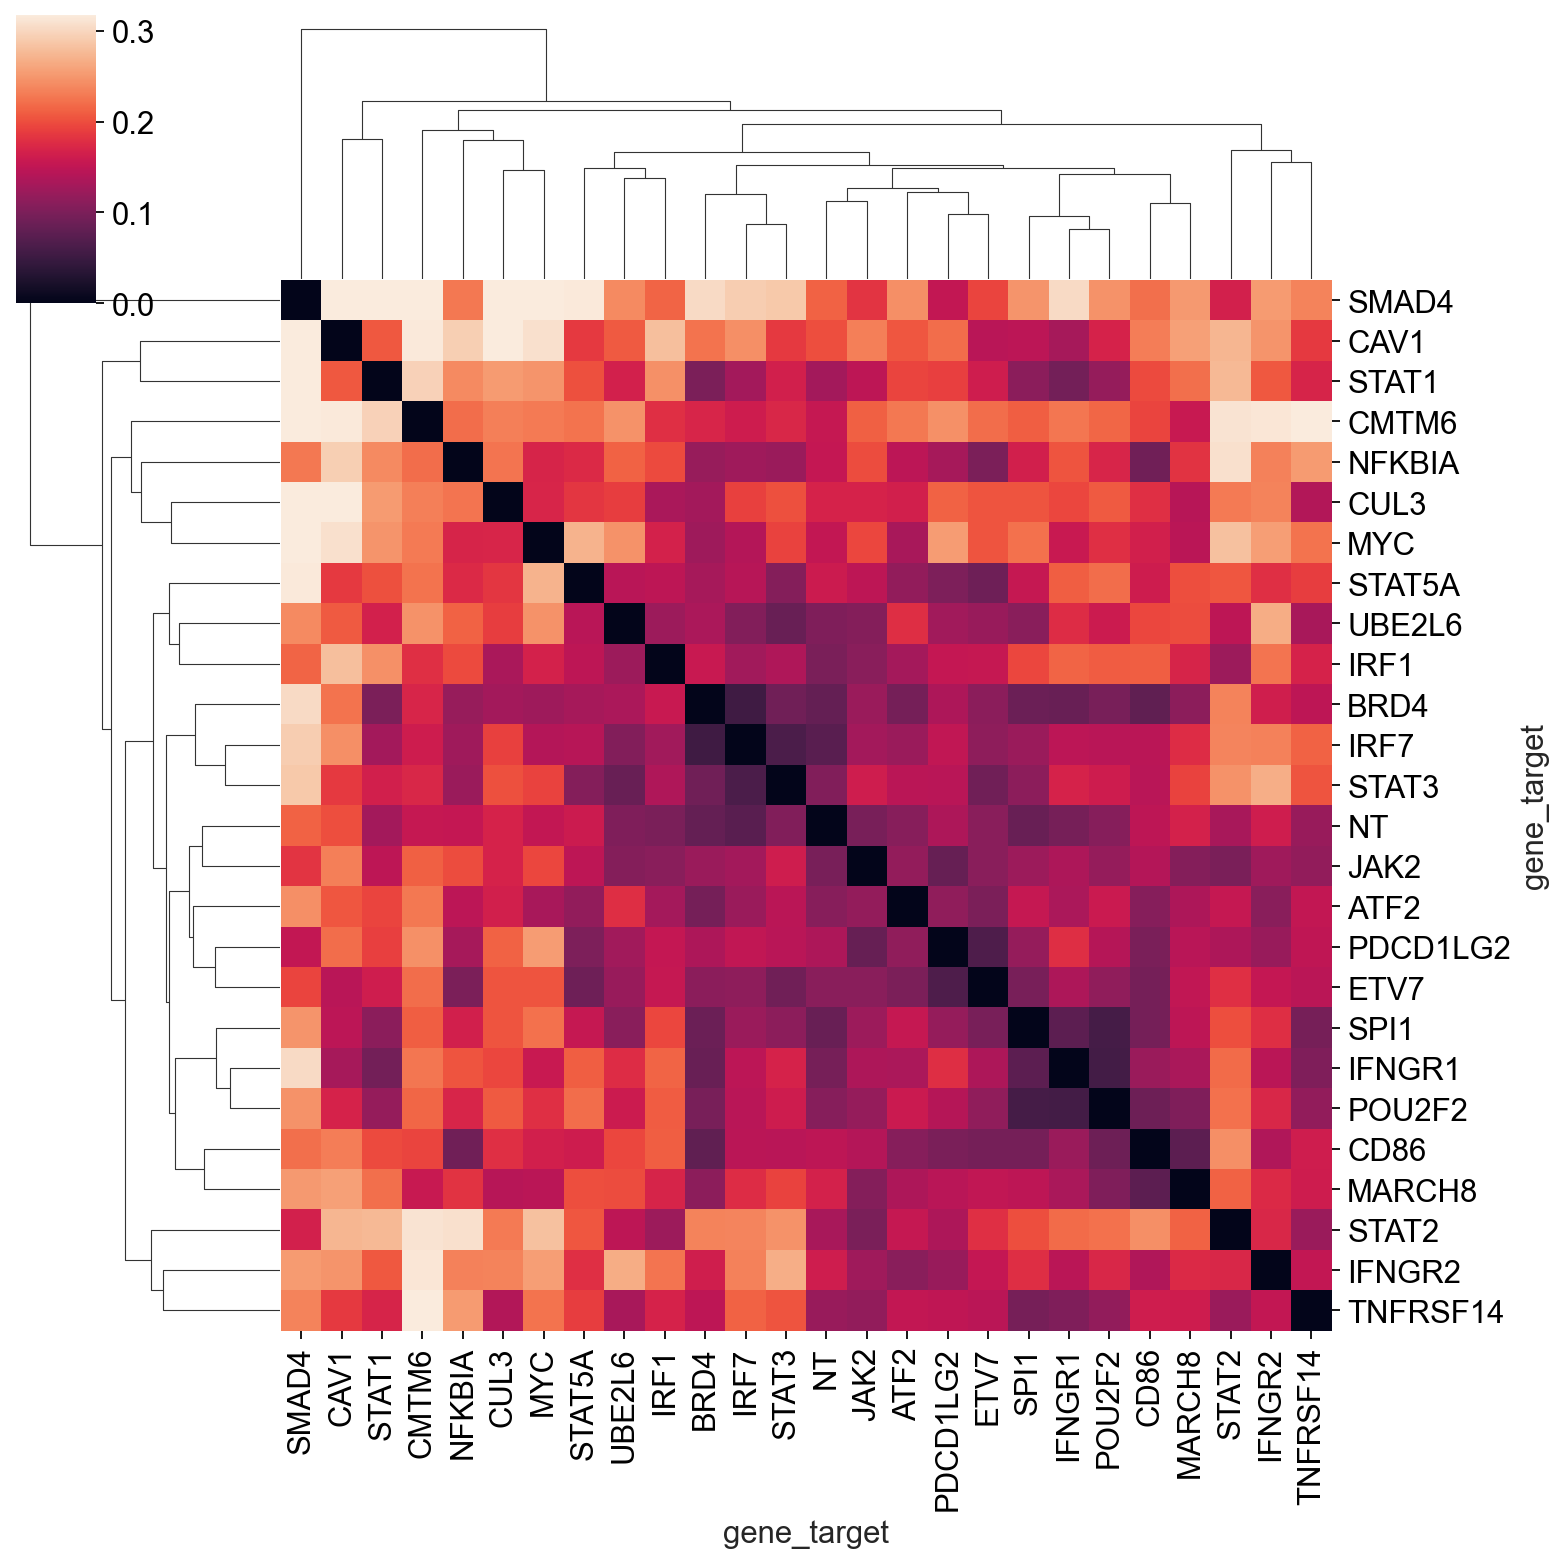

In [27]:
import seaborn as sns

distance = pt.tl.Distance("edistance", obsm_key=SCVI_LATENT_KEY)
df = distance.pairwise(adata_ref, groupby="gene_target")

# Plot the clustermap
sns.clustermap(df, robust=True, figsize=(10, 10))
plt.show()

In [28]:
# Use the function to get the latent representation for px_r
latent_dispersion = guide_model.get_dispersion_latent_representation(adata_ref)

# Store the latent representation in the AnnData object
SCVI_LATENT_KEY_PX_R = "X_scVI_px_r"
adata_ref.obsm[SCVI_LATENT_KEY_PX_R] = latent_dispersion

# Perform UMAP and clustering on the latent representation for px_r
sc.pp.neighbors(adata_ref, use_rep=SCVI_LATENT_KEY_PX_R)
sc.tl.leiden(adata_ref)
sc.tl.umap(adata_ref)

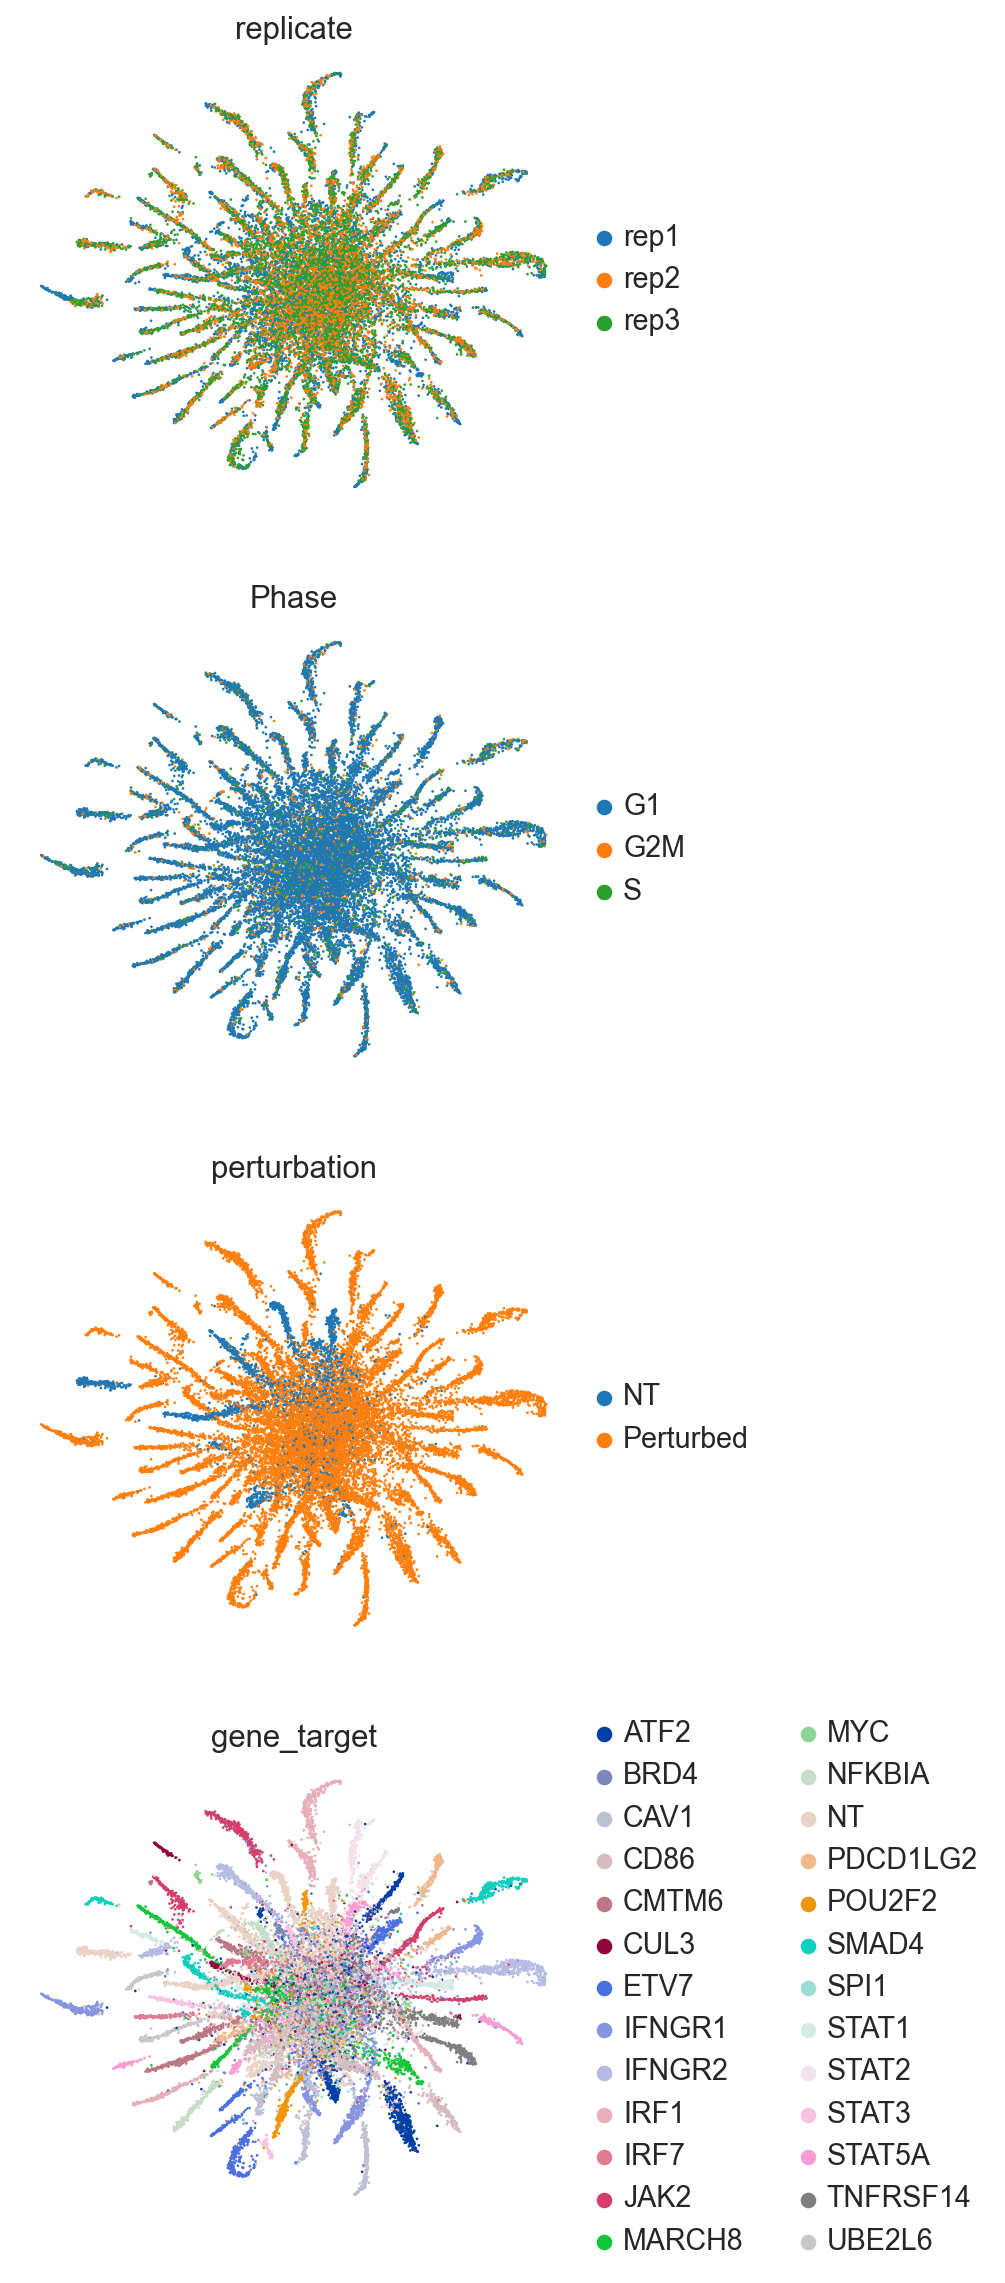

In [30]:
sc.pl.umap(
    adata_ref,
    color=["replicate", "Phase","perturbation","gene_target"],    
    frameon=False,
    ncols=1,
)